<a href="https://colab.research.google.com/github/ramalahamir/image_classification_My_CNN_vs_AlexNet/blob/main/Natural_scenes_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing datset from Kaggle


In [52]:
! pip install kaggle

In [53]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ramalahamir","key":"4bd49f59fcb670513208fcb32748b297"}'}

In [54]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [55]:
!kaggle datasets download -d puneet6060/intel-image-classification

Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
intel-image-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [56]:
!unzip intel-image-classification.zip -d intel-image-classification

Archive:  intel-image-classification.zip
replace intel-image-classification/seg_pred/seg_pred/10004.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Making our own mini CNN

In [57]:
import torch
import torch.nn as nn
import torch.optim as op
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

## Prepping our datasets:

In [58]:
# making our image transformer
transformed = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [59]:
train_path = "/content/intel-image-classification/seg_train/seg_train"
test_path = "/content/intel-image-classification/seg_test/seg_test"

In [60]:
train_dataset = datasets.ImageFolder(root = train_path, transform = transformed)
test_dataset = datasets.ImageFolder(root = test_path, transform = transformed)

In [61]:
print(train_dataset.classes)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [62]:
print(train_dataset.class_to_idx)

{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


In [63]:
# defining our class dict
classes = {0 : 'buildings', 1 : 'forest', 2 : 'glacier', 3 : 'mountain', 4 : 'sea', 5 : 'street'}

## checking if our data is balanced

In [64]:
from collections import Counter

In [65]:
print(Counter(train_dataset.targets))

Counter({3: 2512, 2: 2404, 5: 2382, 4: 2274, 1: 2271, 0: 2191})


In [66]:
print(Counter(test_dataset.targets))

Counter({2: 553, 3: 525, 4: 510, 5: 501, 1: 474, 0: 437})


data is balanced!

In [67]:
# making batches
training_batches = DataLoader(train_dataset, batch_size = 32, shuffle = True)
testing_batches = DataLoader(test_dataset, batch_size = 32)

## Defining our CNN:

In [68]:
class my_CNN(nn.Module):
   def __init__(self):
      super().__init__()

      self.my_model = nn.Sequential(
          # layer 1:
          nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = (3,3), padding = 1),
          nn.BatchNorm2d(32),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size = (2,2), stride = 2),
          # output feature map size: 64x64x32

          # layer 2:
          nn.Conv2d(32, 64, 3, padding = 1),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.MaxPool2d(2,2),
          # output feature map size: 32x32x64

          # flattening for the neural network
          nn.Flatten(),
          # neural network layers (making 3 layers)
          nn.Linear(in_features = 32*32*64, out_features = 128),
          nn.BatchNorm1d(128),
          nn.ReLU(),
          nn.Linear(128, 64),
          nn.BatchNorm1d(64),
          nn.ReLU(),
          nn.Linear(64, 6),    # since 6 classes

          nn.Dropout(0.3)
      )

   def forward(self, image_batch):
     return self.my_model(image_batch)

## Training the model

In [69]:
miniCnn = my_CNN()
miniCnn.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
miniCnn.to(miniCnn.device)
loss_func = nn.CrossEntropyLoss()
optimizer = op.Adam(miniCnn.parameters(), lr = 0.0001)

In [70]:
print("Using device:", miniCnn.device)


Using device: cpu


keeping track of training losses and validation accuracies for comparison of models

In [71]:
train_loss_myCnn = []
val_acc_myCnn = []

for confusion matrix

In [72]:
predicted_classes_myCnn = []
actual_classes_myCnn = []

In [73]:
# counter = 0
# patience = 10
# best_acc = 0

# for epoch in range(50):

#   miniCnn.train()
#   total_loss = 0

#   for images, labels in training_batches:
#     images, labels = images.to(miniCnn.device), labels.to(miniCnn.device)

#     optimizer.zero_grad()
#     outputs = miniCnn(images)
#     loss = loss_func(outputs, labels)
#     loss.backward()
#     optimizer.step()

#     total_loss += loss.item()

#   # validating the model
#   miniCnn.eval()
#   correct = 0
#   total = 0

#   with torch.no_grad():
#     for images, labels in testing_batches:
#       images, labels = images.to(miniCnn.device), labels.to(miniCnn.device)

#       outputs = miniCnn(images)   # getting a tensor of class scores
#       _, predicted = torch.max(outputs.data, 1)   # finding the max along horizontal axis
#       total += labels.size(0)  # getting the batch size
#       correct += (predicted == labels).sum().item()

#       # storing the actual vs predicted info for confusion matrix
#       predicted_classes_myCnn.extend(predicted.cpu().numpy())
#       actual_classes_myCnn.extend(labels.cpu().numpy())

#   accuracy = 100*correct/total
#   print(f"Epoch: ", {epoch}, " loss: ", {total_loss}, " accuracy: ", {accuracy})

#   # per epochs storing the loss and accuracy
#   train_loss_myCnn.append(total_loss)
#   val_acc_myCnn.append(accuracy)

#   if accuracy > best_acc:
#     best_acc = accuracy
#     counter = 0
#     torch.save(miniCnn.state_dict(), "best_model.pth")
#   else:
#     counter += 1
#     if counter >= patience:
#       print("Early stopping triggered")
#       break

we reached an approximate accuracy of 82-83%

In [74]:
import pickle

In [75]:
# # saving our states to avoid training again

# files.download("best_model.pth")

# # Saving our lists to a .pkl file
# with open("training_stats.pkl", "wb") as f:
#     pickle.dump({
#         'train_loss': train_loss_myCnn,
#         'val_accuracy': val_acc_myCnn,
#         'pred_classes': predicted_classes_myCnn,
#         'actual_classes': actual_classes_myCnn
#     }, f)

# files.download("training_stats.pkl")


In [76]:
# Upload the .pkl file from your PC
uploaded = files.upload()

# Loading the lists
with open("training_stats.pkl", "rb") as f:
    stats = pickle.load(f)

# Assigning back to your original lists
train_loss_myCnn = stats['train_loss']
val_acc_myCnn = stats['val_accuracy']
predicted_classes_myCnn = stats['pred_classes']
actual_classes_myCnn = stats['actual_classes']

Saving training_stats.pkl to training_stats (1).pkl


Plotting our Train loss and validation Accuracy plots


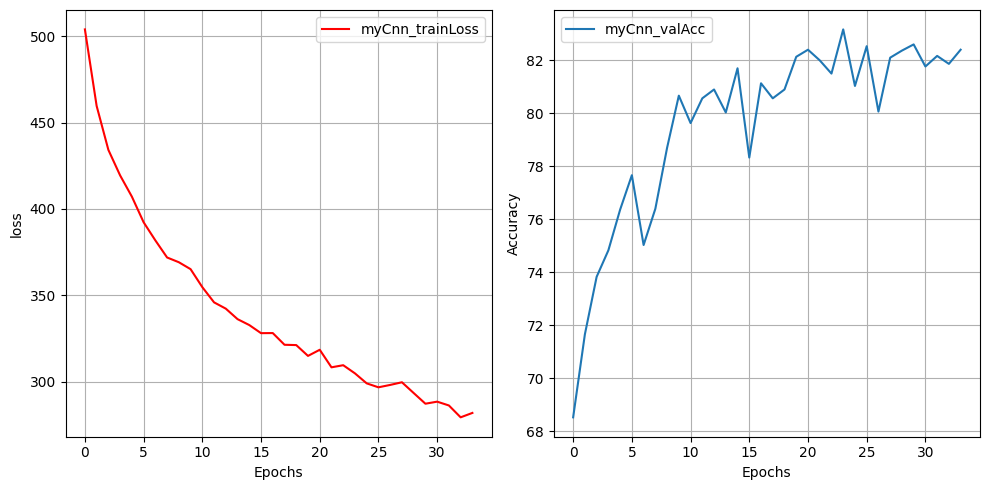

In [77]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].plot(train_loss_myCnn, label="myCnn_trainLoss", color="Red")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("loss")
axes[0].grid()
axes[0].legend()

axes[1].plot(val_acc_myCnn, label="myCnn_valAcc")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Accuracy")
axes[1].grid()
axes[1].legend()

plt.tight_layout()
plt.show()

making the confusion matrix

In [78]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

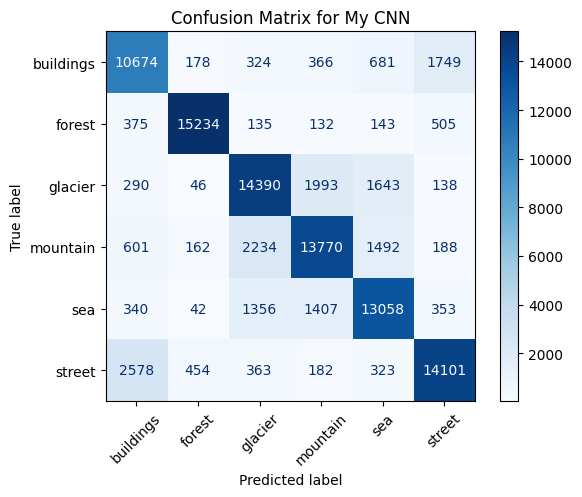

In [79]:
cm = confusion_matrix(predicted_classes_myCnn, actual_classes_myCnn)
display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = classes.values())
display.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix for My CNN")
plt.show()

Getting accuracy per class

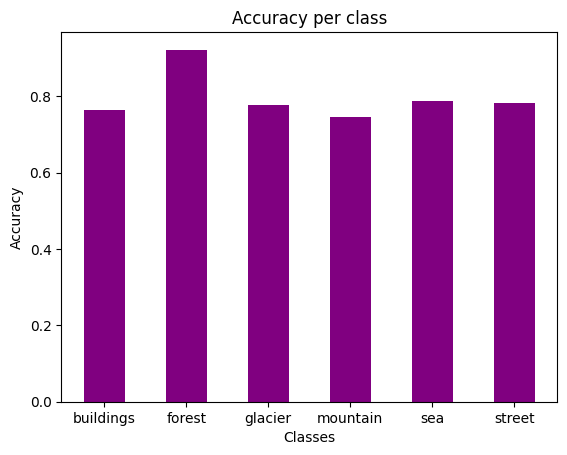

In [80]:
acc_per_class = cm.diagonal() / cm.sum(axis = 1)
plt.bar(classes.values(), acc_per_class, color = 'purple', width = 0.5)
plt.xlabel("Classes")
plt.ylabel("Accuracy")
plt.title("Accuracy per class")
plt.show()

## Testing our best trained model




In [81]:
uploaded = files.upload()

Saving best_model.pth to best_model (1).pth


In [82]:
# making a new model according to saved best states
my_model = my_CNN().to(miniCnn.device)
my_model.load_state_dict(torch.load("best_model.pth", map_location=torch.device('cpu')))
my_model.eval()

my_CNN(
  (my_model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=65536, out_features=128, bias=True)
    (10): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Linear(in_features=128, out_features=64, bias=True)
    (13): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Linear(in_features=64, out_features=6, bi

In [83]:
from PIL import Image
import random
import os

(np.float64(-0.5), np.float64(149.5), np.float64(149.5), np.float64(-0.5))

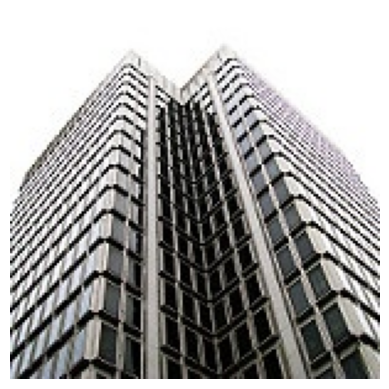

In [84]:
# prepping our image for testing
folder = "/content/intel-image-classification/seg_pred/seg_pred"
img_path = folder + "/" + random.choice(os.listdir(folder))
img = Image.open(img_path)
img = img.convert("RGB")

plt.imshow(img)
plt.axis("off")

In [85]:
img = transformed(img)
img = img.unsqueeze(0)  # adding batch size
img = img.to(miniCnn.device)

In [86]:
with torch.no_grad():
  output = my_model(img)
  _,predicted_class = torch.max(output.data, 1)

print ("class: ", classes[predicted_class.item()])

class:  buildings


# Comparing my model with AlexNet

In [87]:
from torchvision import models

In [88]:
transformed_alexNet = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [89]:
alexnet = models.alexnet(pretrained = True)
alexnet

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [90]:
# freezing the parameters
for params in alexnet.parameters():
  params.requires_grad = False

In [91]:
# adjusting alexnet to our dateset classification
alexnet.classifier[6] = nn.Linear(4096, 6)     # adjusting the last layer to our class number

In [92]:
from torchsummary import summary
summary(alexnet, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

In [93]:
alexnet.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alexnet.to(alexnet.device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [94]:
# training alexnet on our dataset
loss_func_alexNet = nn.CrossEntropyLoss()
optimizer_alexNet = op.Adam(alexnet.parameters(), lr = 0.001)

In [95]:
train_dataset_alexNet = datasets.ImageFolder("/content/intel-image-classification/seg_train/seg_train", transform=transformed_alexNet)
test_dataset_alexNet = datasets.ImageFolder("/content/intel-image-classification/seg_test/seg_test", transform=transformed_alexNet)

In [96]:
training_batches_alexNet = DataLoader(train_dataset_alexNet, batch_size = 32, shuffle = True)
testing_batches_alexNet = DataLoader(test_dataset_alexNet, batch_size = 32)

In [97]:
# for comparison
train_loss_alexNet = []
val_acc_alexNet = []

In [98]:
# for confusion matrix
predicted_classes_alexNet = []
actual_classes_alexNet = []

In [99]:
# counter = 0
# patience = 5
# best_acc = 0

# for epoch in range(10):

#   alexnet.train()
#   total_loss = 0

#   for images, labels in training_batches_alexNet:
#     images, labels = images.to(alexnet.device), labels.to(alexnet.device)

#     optimizer_alexNet.zero_grad()
#     outputs = alexnet(images)
#     loss = loss_func_alexNet(outputs, labels)
#     loss.backward()
#     optimizer_alexNet.step()

#     total_loss += loss.item()

#   # validating the model
#   alexnet.eval()
#   correct = 0
#   total = 0

#   with torch.no_grad():
#     for images, labels in testing_batches_alexNet:
#       images, labels = images.to(alexnet.device), labels.to(alexnet.device)

#       outputs = alexnet(images)   # getting a tensor of class scores
#       _, predicted = torch.max(outputs.data, 1)   # finding the max along horizontal axis
#       total += labels.size(0)  # getting the batch size
#       correct += (predicted == labels).sum().item()

#       # storing the actual vs predicted info for confusion matrix
#       predicted_classes_alexNet.extend(predicted.cpu().numpy())
#       actual_classes_alexNet.extend(labels.cpu().numpy())

#   accuracy = 100*correct/total
#   print(f"Epoch: ", {epoch}, " loss: ", {total_loss}, " accuracy: ", {accuracy})

#   # per epochs storing the loss and accuracy
#   train_loss_alexNet.append(total_loss)
#   val_acc_alexNet.append(accuracy)

#   if accuracy > best_acc:
#     best_acc = accuracy
#     counter = 0
#     torch.save(alexnet.state_dict(), "best_model_alexnet.pth")
#   else:
#     counter += 1
#     if counter >= patience:
#       print("Early stopping triggered")
#       break

Alexnet has reached an accuracy of 86%

In [100]:
# # saving our states to avoid training again

# files.download("best_model_alexnet.pth")

# # Saving our lists to a .pkl file
# with open("training_stats_alexnet.pkl", "wb") as f:
#     pickle.dump({
#         'train_loss': train_loss_alexNet,
#         'val_accuracy': val_acc_alexNet,
#         'pred_classes': predicted_classes_alexNet,
#         'actual_classes': actual_classes_alexNet
#     }, f)

# files.download("training_stats_alexnet.pkl")


In [101]:
# Upload the .pkl file from your PC
uploaded = files.upload()

# Loading the lists
with open("training_stats_alexnet.pkl", "rb") as f:
    stats = pickle.load(f)

# Assigning back to your original lists
train_loss_alexNet = stats['train_loss']
val_acc_alexNet = stats['val_accuracy']
predicted_classes_alexNet = stats['pred_classes']
actual_classes_alexNet = stats['actual_classes']

Saving training_stats_alexnet.pkl to training_stats_alexnet (1).pkl


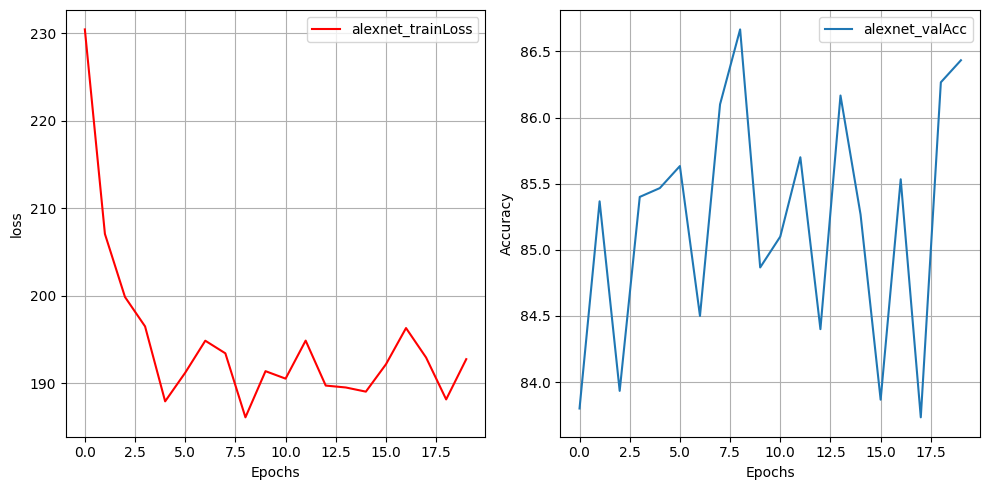

In [103]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].plot(train_loss_alexNet, label="alexnet_trainLoss", color="Red")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("loss")
axes[0].grid()
axes[0].legend()

axes[1].plot(val_acc_alexNet, label="alexnet_valAcc")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Accuracy")
axes[1].grid()
axes[1].legend()

plt.tight_layout()
plt.show()

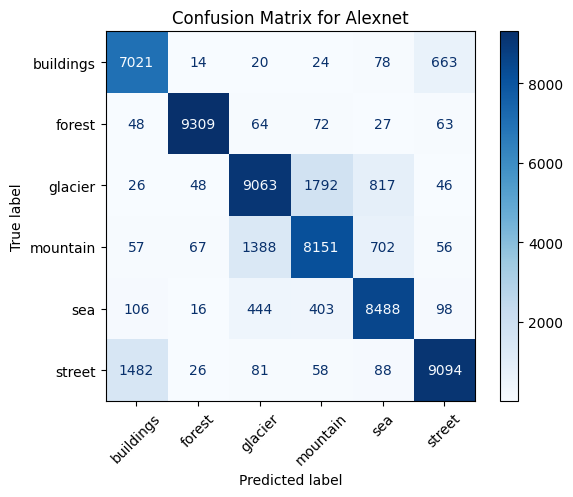

In [104]:
cm_alexnet = confusion_matrix(predicted_classes_alexNet, actual_classes_alexNet)
display = ConfusionMatrixDisplay(confusion_matrix = cm_alexnet, display_labels = classes.values())
display.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix for Alexnet")
plt.show()

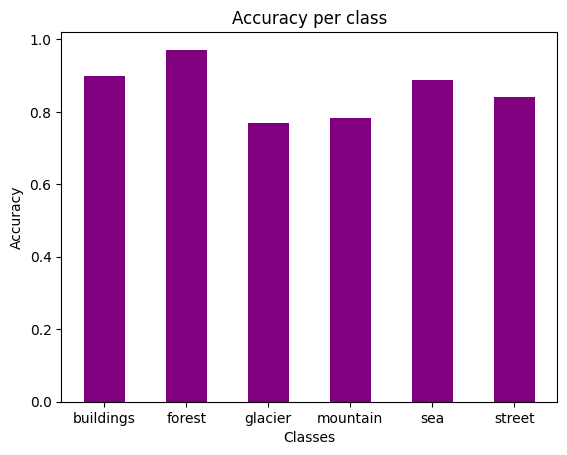

In [105]:
acc_per_class_alexnet = cm_alexnet.diagonal() / cm_alexnet.sum(axis = 1)
plt.bar(classes.values(), acc_per_class_alexnet, color = 'purple', width = 0.5)
plt.xlabel("Classes")
plt.ylabel("Accuracy")
plt.title("Accuracy per class")
plt.show()

In [1]:
uploaded = files.upload()

NameError: name 'files' is not defined

In [ ]:
# making a new model according to saved best states
alexNet_model = alexnet.to(alexnet.device)
alexNet_model.load_state_dict(torch.load("best_model_alexnet.pth", map_location=torch.device('cpu')))
alexNet_model.eval()

In [ ]:
# predicting the same image on alexnet
img = transformed_alexNet(img)
img = img.unsqueeze(0)  # adding batch size
img = img.to(alexnet.device)

In [ ]:
with torch.no_grad():
  output = alexNet_model(img)
  _,predicted_class = torch.max(output.data, 1)

print ("class: ", classes[predicted_class.item()])